In [1]:
import numpy as np
import helper_functions as hp
import matplotlib.pyplot as plt

from sklearn.preprocessing import OneHotEncoder
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from keras import backend as K
import py_compile



2022-11-20 21:55:36.607888: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-20 21:55:36.731920: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
segmented_naip_images_tif, segmented_naip_new_labels = hp.segmented_dataset_reader('naip_2018_chips_90m_3class_180stride_segment')


reading in 5064 images


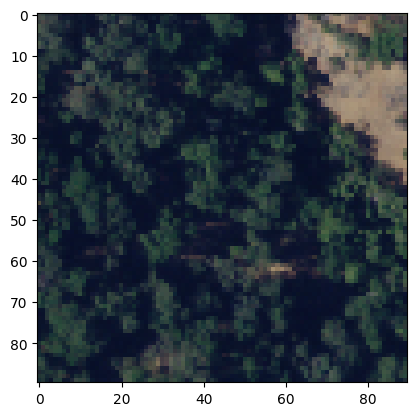

In [3]:
img = segmented_naip_images_tif[2300 , : , : , 0:3]
plt.imshow(img)

In [3]:
segmented_naip_new_labels = segmented_naip_new_labels[:,:,:,0:3]
segmented_naip_new_labels.max()
#plt.imshow(lbl)


3

In [4]:
train_images, test_images, train_labels, test_labels = train_test_split(segmented_naip_images_tif, segmented_naip_new_labels, test_size=.2, shuffle=True)


In [5]:
model = hp.get_simple_unet_model(segmented_naip_images_tif[0].shape)
model.summary()

2022-11-20 21:55:45.759710: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-20 21:55:46.527876: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1616] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9637 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2080 Ti, pci bus id: 0000:67:00.0, compute capability: 7.5
2022-11-20 21:55:46.528478: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1616] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 9636 MB memory:  -> device: 1, name: NVIDIA GeForce RTX 2080 Ti, pci bus id: 0000:68:00.0, compute capability: 7.5


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 90, 90, 4)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 44, 44, 32)   1184        ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 44, 44, 32)  128         ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                                  
 activation (Activation)        (None, 44, 44, 32)   0           ['batch_normalization[0][0]']

In [ ]:
test_init = hp.get_test_accuracy(model, test_images, test_labels)
train_init = hp.get_train_accuracy(model, train_images, train_labels)

In [6]:
history = model.fit(train_images, train_labels, epochs=10, validation_data=(test_images, test_labels))

Epoch 1/10


2022-11-20 21:55:59.221088: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8100


127/127 [==============================] - 9s 42ms/step - loss: -36184498176.0000 - accuracy: 0.8417 - val_loss: -165981896704.0000 - val_accuracy: 0.8165
Epoch 2/10
127/127 [==============================] - 4s 34ms/step - loss: -224229404442624.0000 - accuracy: 0.7658 - val_loss: -1208727143186432.0000 - val_accuracy: 0.7594
Epoch 3/10
127/127 [==============================] - 4s 34ms/step - loss: -35386319303606272.0000 - accuracy: 0.7554 - val_loss: -187160278029303808.0000 - val_accuracy: 0.7715
Epoch 4/10
127/127 [==============================] - 4s 34ms/step - loss: -1002125477722193920.0000 - accuracy: 0.7506 - val_loss: -3338790477922041856.0000 - val_accuracy: 0.7557
Epoch 5/10
127/127 [==============================] - 4s 34ms/step - loss: -13109791598298791936.0000 - accuracy: 0.7481 - val_loss: -36861650688725221376.0000 - val_accuracy: 0.7598
Epoch 6/10
127/127 [==============================] - 4s 34ms/step - loss: -96638047290069614592.0000 - accuracy: 0.7473 - val_lo